In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import os

## (a) Load CIFAR-100 Dataset

In [2]:
original = False

if original:
    transform = transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale = True)
        ])
else:
    transform = models.MobileNet_V3_Small_Weights.DEFAULT.transforms()


# import the CIFAR100 dataset
dataset_root = '../datasets'
train_dataset_ = torchvision.datasets.CIFAR100(root=dataset_root, train = True, download = True, transform = transform)
test_dataset = torchvision.datasets.CIFAR100(root=dataset_root, train = False, download = True, transform = transform)

100%|██████████| 169M/169M [00:16<00:00, 10.3MB/s] 


In [3]:
### Dataset exploration, no changes required here
targets = np.array(train_dataset_.targets)
print(f'  {"Name":10s} Count')
for ix in range(targets.max()):
  print(f'{ix} {train_dataset_.classes[ix]:10s} {sum(targets == ix)}')
print()
# The data is stored in a tensor with the following dimensions
print(f'Dimensions of training dataset tensor:\n\t{train_dataset_.data.shape}\n')
print(f'Dimensions of testing dataset tensor:\n\t{test_dataset.data.shape}')
print()
print(f'Dataset target labels:\n\t{train_dataset_.classes}\n')
print(f'Dataset target dimensions:\n\t{len(train_dataset_.targets)}')
print()
print(f'Max value: {train_dataset_.data.max()}')
print(f'Min value: {train_dataset_.data.min()}')

  Name       Count
0 apple      500
1 aquarium_fish 500
2 baby       500
3 bear       500
4 beaver     500
5 bed        500
6 bee        500
7 beetle     500
8 bicycle    500
9 bottle     500
10 bowl       500
11 boy        500
12 bridge     500
13 bus        500
14 butterfly  500
15 camel      500
16 can        500
17 castle     500
18 caterpillar 500
19 cattle     500
20 chair      500
21 chimpanzee 500
22 clock      500
23 cloud      500
24 cockroach  500
25 couch      500
26 crab       500
27 crocodile  500
28 cup        500
29 dinosaur   500
30 dolphin    500
31 elephant   500
32 flatfish   500
33 forest     500
34 fox        500
35 girl       500
36 hamster    500
37 house      500
38 kangaroo   500
39 keyboard   500
40 lamp       500
41 lawn_mower 500
42 leopard    500
43 lion       500
44 lizard     500
45 lobster    500
46 man        500
47 maple_tree 500
48 motorcycle 500
49 mountain   500
50 mouse      500
51 mushroom   500
52 oak_tree   500
53 orange     500
54 orchid     5

# Visualize the Dataset

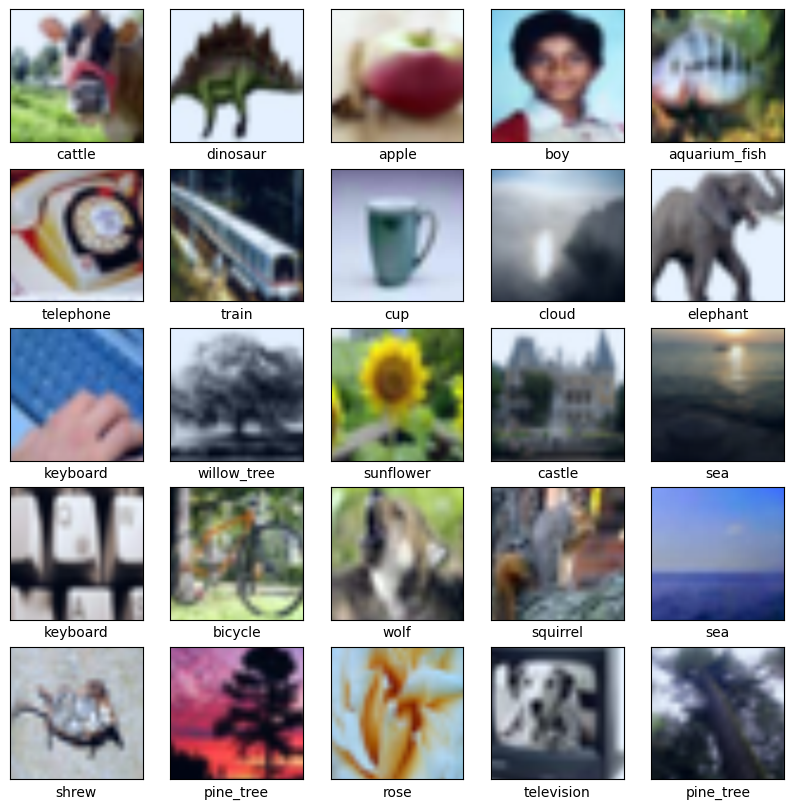

In [4]:
### No changes required here
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
# Show first 25 training images below
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = train_dataset_[i][0].permute(1,2,0)
    img = img - img.min()
    img = img / img.max()
    plt.imshow(img, cmap=plt.cm.gray)
    plt.xlabel(train_dataset_.classes[train_dataset_[i][1]])

## (b) Create Validation Dataset

In [5]:
### Use random_split to make a validation dataset from the training dataset.
train_size = int(0.8 * len(train_dataset_))
val_size = len(train_dataset_) - train_size

train_dataset, val_dataset = random_split(train_dataset_, [train_size, val_size])

## (c) Setup DataLoaders

In [6]:
### Make a validation dataset loader and set batch size
batch_size = 128 # set it
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## (d) Modify Pre-Trained Model

In [7]:
pre_trained_model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
print(pre_trained_model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/luanjie/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 59.5MB/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [8]:
print(pre_trained_model.classifier)

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)


In [9]:
print(f'Original number of classes: {pre_trained_model.classifier[-1].out_features}')

Original number of classes: 1000


In [10]:
def make_new_model(learning_rate, output_layer_size,pre_trained_model):
    # Download the pre-trained MobileNetV3 Small model
    model = pre_trained_model

    # Remove the output layer and replace with at least one
    # hidden layer, an activation function, and an output layer
    
    num_features = model.classifier[0].in_features

    model.classifier = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.BatchNorm1d(256),
        nn.GELU(),
        nn.Dropout(0.3),
        nn.Linear(256, output_layer_size)
    )

    return model


## (e) Set Hyperparameters

In [11]:
### You may added additional hyperparameters here
training_epochs = 100
learning_rate = 2e-4
output_layer_size = 100

The code is used to compile predictions and losses for one epoch.

In [12]:
### No changes required here
def check_performance(model, loss, loader, device):
  """
  Return dictionary of performance statistics.
  Arguments:
    model - Instance of network architecture
    loss - Loss function
    loader - DataLoader object from which to compile statistics
    device - either CPU or CUDA device

  Returns:
    dictionary with the following keys:
    'losses': Loss for each minibatch
    'predictions': Predicted class for each item in minibatch
    'targets': True label for each item in minibatch
  """
  losses = []
  all_preds = []
  all_targets = []

  #The eval mode and torch.no_grad are called to avoid computing things not
  # required for a forward pass, like gradient computations
  model.eval()
  with torch.no_grad():
    for features, target in loader:
      predictions = model(features.to(device))
      # Compute the loss with the testing data.  This should track the training
      # loss, at least at the start of training.
      error = loss(predictions, target.to(device))
      losses.append(error.item())

      preds = predictions.argmax(axis=1)
      all_preds.append(preds)
      all_targets.append(target)

  return {'losses': losses,
          'predictions': torch.hstack(all_preds).cpu(),
          'targets': torch.hstack(all_targets).cpu()
          }

## Training loop

In [13]:
### No changes required here, but you may wish to change the optimizer or loss.

#Make instance of the network
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:',device)
model = make_new_model(learning_rate, output_layer_size,pre_trained_model).to(device)

# Loss function
loss = torch.nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
# Optimizer - Can experiment with ADAM, SGD, etc.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)


# performance statistics for each epoch
stats_per_epoch = {
  'train_loss': [],
  'train_accuracy': [],
  'val_loss': [],
  'val_accuracy': []
  }

best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
epochs_no_improve = 0
early_stop = False

model.train()  # Put model in train mode so it tracks gradients, etc. for optimization
for i in range(training_epochs):
  if early_stop:
        print("Early stopping triggered!")
        break
      
  print(f'Epoch: {i}')
  train_losses = []
  train_correct = 0
  train_total = 0

  for features, target in tqdm(train_loader):
    optimizer.zero_grad()                       # do not accumulate gradients

    features = features.to(device)
    target = target.to(device)

    predictions = model(features)               # forward pass
    error = loss(predictions, target)           # compute loss
    train_losses.append(error.item())

    _, predicted = torch.max(predictions.data, 1)
    train_total += target.size(0)
    train_correct += (predicted == target).sum().item()

    error.backward()                            # backward pass
    optimizer.step()                            # update weights

  # Per epoch stats
  stats_per_epoch['train_loss'].append(np.mean(train_losses))
  stats_per_epoch['train_accuracy'].append(train_correct / train_total)
  perf = check_performance(model, loss, val_loader, device)
  current_val_loss = np.mean(perf['losses'])  
  current_val_acc = (sum(perf['targets'] == perf['predictions']) / len(perf['targets'])).item()

  stats_per_epoch['val_loss'].append(current_val_loss)
  stats_per_epoch['val_accuracy'].append(current_val_acc)

  print(f'\tMean train loss: {stats_per_epoch["train_loss"][-1]:.3f}')
  print(f'\tMean validation loss: {current_val_loss:.3f}')
  print(f'\tMean train accuracy: {stats_per_epoch["train_accuracy"][-1]:.3f}')
  print(f'\tMean validation accuracy: {current_val_acc:.3f}')
  
  # EARLY STOPPING
  if current_val_loss < best_val_loss:
      best_val_loss = current_val_loss
      epochs_no_improve = 0
  else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
          early_stop = True
  

# End of run stats
test_perf = check_performance(model, loss, test_loader, device)
stats_per_epoch['test_loss'] = np.mean(test_perf['losses'])
stats_per_epoch['test_accuracy'] = (sum(test_perf['targets'] == test_perf['predictions']) / len(test_perf['targets'])).item()

print(f'Mean test loss: {stats_per_epoch["test_loss"]:.3f}')
print(f'Mean test accuracy: {stats_per_epoch["test_accuracy"]:.3f}')


Device is: cuda
Epoch: 0


  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:28<00:00, 10.93it/s]


	Mean train loss: 3.118
	Mean validation loss: 2.447
	Mean train accuracy: 0.395
	Mean validation accuracy: 0.557
Epoch: 1


100%|██████████| 313/313 [00:25<00:00, 12.39it/s]


	Mean train loss: 1.787
	Mean validation loss: 1.685
	Mean train accuracy: 0.685
	Mean validation accuracy: 0.719
Epoch: 2


100%|██████████| 313/313 [00:25<00:00, 12.42it/s]


	Mean train loss: 1.514
	Mean validation loss: 1.612
	Mean train accuracy: 0.780
	Mean validation accuracy: 0.740
Epoch: 3


100%|██████████| 313/313 [00:25<00:00, 12.47it/s]


	Mean train loss: 1.376
	Mean validation loss: 1.565
	Mean train accuracy: 0.831
	Mean validation accuracy: 0.755
Epoch: 4


100%|██████████| 313/313 [00:25<00:00, 12.43it/s]


	Mean train loss: 1.280
	Mean validation loss: 1.549
	Mean train accuracy: 0.869
	Mean validation accuracy: 0.764
Epoch: 5


100%|██████████| 313/313 [00:25<00:00, 12.33it/s]


	Mean train loss: 1.199
	Mean validation loss: 1.537
	Mean train accuracy: 0.902
	Mean validation accuracy: 0.772
Epoch: 6


100%|██████████| 313/313 [00:27<00:00, 11.48it/s]


	Mean train loss: 1.130
	Mean validation loss: 1.548
	Mean train accuracy: 0.929
	Mean validation accuracy: 0.771
Epoch: 7


100%|██████████| 313/313 [00:26<00:00, 11.68it/s]


	Mean train loss: 1.074
	Mean validation loss: 1.560
	Mean train accuracy: 0.952
	Mean validation accuracy: 0.760
Epoch: 8


100%|██████████| 313/313 [00:27<00:00, 11.44it/s]


	Mean train loss: 1.029
	Mean validation loss: 1.556
	Mean train accuracy: 0.966
	Mean validation accuracy: 0.766
Early stopping triggered!
Mean test loss: 1.559
Mean test accuracy: 0.765


## (h) Plot Your Results

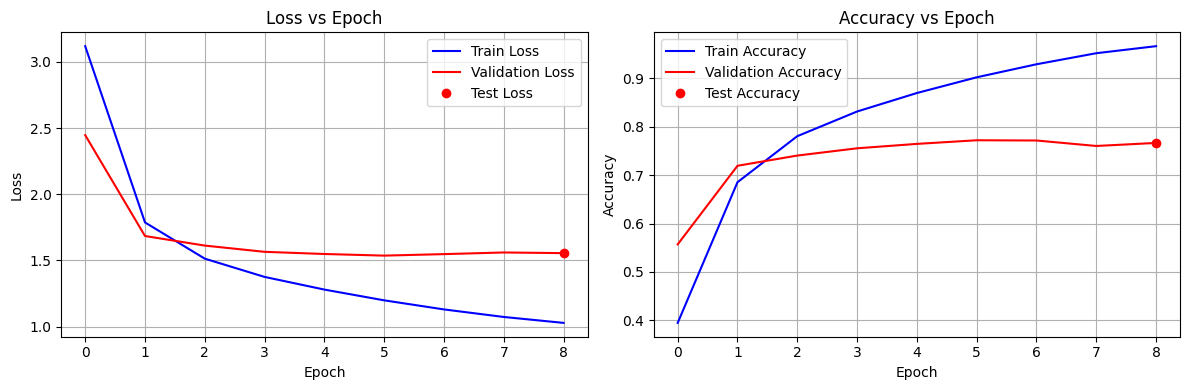

In [14]:
epochs = range(len(stats_per_epoch['train_loss']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot Loss
ax1.plot(epochs, stats_per_epoch['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, stats_per_epoch['val_loss'], 'r-', label='Validation Loss')

last_epoch = len(epochs) - 1
ax1.plot(last_epoch, stats_per_epoch['test_loss'], 'ro', label='Test Loss')  

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Epoch')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, stats_per_epoch['train_accuracy'], 'b-', label='Train Accuracy')
ax2.plot(epochs, stats_per_epoch['val_accuracy'], 'r-', label='Validation Accuracy')

ax2.plot(last_epoch, stats_per_epoch['test_accuracy'], 'ro', label='Test Accuracy')  

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch')
ax2.legend()
ax2.grid(True)

plt.savefig(f'plots/cnn_{learning_rate}_{batch_size}_{training_epochs}_{original}.png')
plt.tight_layout()
plt.show()


# Visualize the Predictions

In [15]:
# Code to visualize predictions
# Incorrect predictions are highlighted in red
def visualize(dataset, stats, errors = None):
  if errors is None:
    errors = []
    print('Correct Label in ()')
  else:
    print(f'Errors where true label is {dataset.classes[stats["targets"][errors[0]]]}')

  plt.figure(figsize=(10,10))
  for i in range(min(len(errors), 25) if len(errors) else 25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      j = errors[i] if len(errors) else i

      img = dataset[j][0].permute(1,2,0)
      img = img - img.min()
      img = img / img.max()
      plt.imshow(img, cmap=plt.cm.gray)
      predicted_label = stats['predictions'][j]
      true_label = stats['targets'][j]
      if predicted_label == true_label:
        color = 'green'
      else:
        color = 'red'
      plt.xlabel("{} ({})".format(dataset.classes[predicted_label],
                                  dataset.classes[true_label]),
                                  color=color)

Correct Label in ()


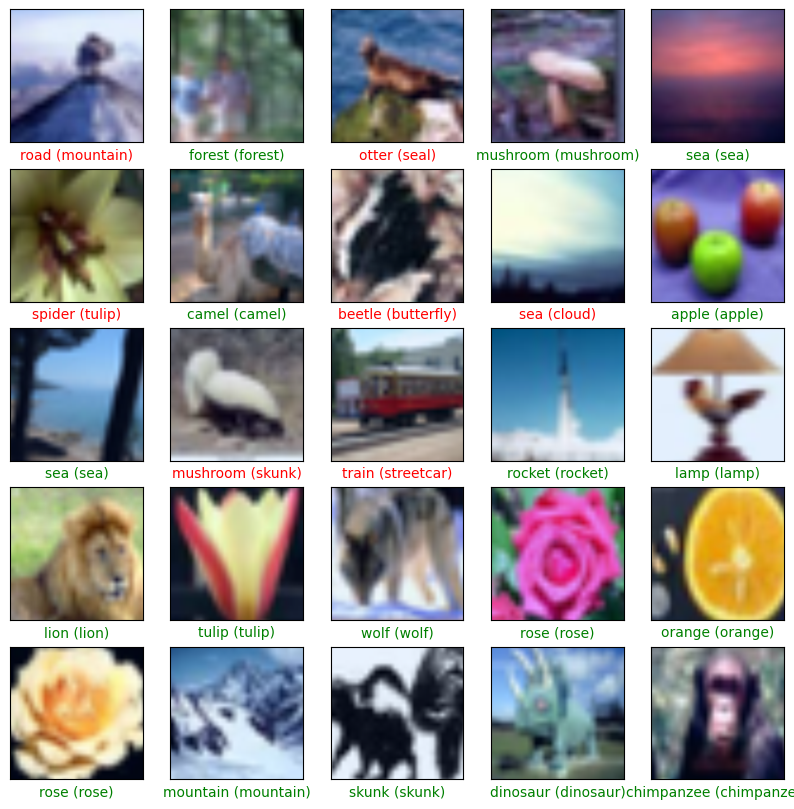

In [16]:
### Show first 25 predictions
visualize(test_dataset, test_perf)

Errors where true label is bear


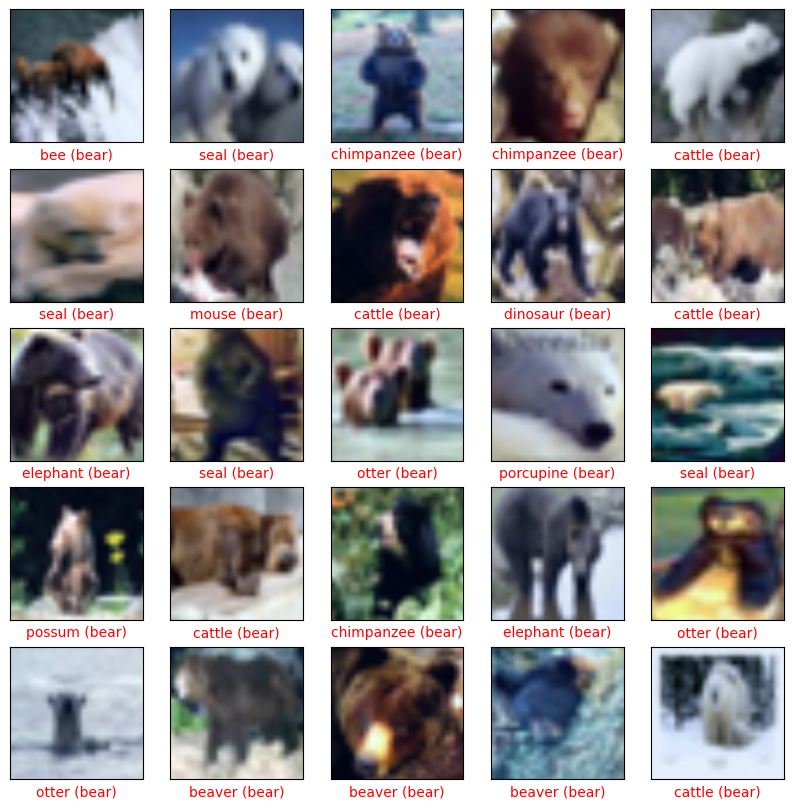

In [17]:
### Show first 25 predictions that are incorrect for a specific class

# get a list of indices where there is an error
true_class_ix = 3 # expected class is 3 (cat)
errors = np.where(test_perf['targets'] != test_perf['predictions'])[0]
e2 = np.where(test_perf['targets']==true_class_ix)[0]
errors = np.intersect1d(e2,errors)

visualize(test_dataset, test_perf, errors)